# Logistic regression on social network ads (nalyst)

## nalyst 2.1.1

- **Author:** Hemant Thapa  
- **License:** MIT  
- **Python:** ≥ 3.10  

**Nalyst** is a full-stack machine learning toolkit with a unified `train()` / `infer()` API covering:
machine learning, statistics, time series, survival analysis, deep learning, AutoML, and explainability.

**Install:**
```bash
pip install nalyst==2.1.1
```

### Step 1: Import libraries
Load NumPy/Pandas, Nalyst helpers, metrics, and plotting utilities for the workflow.

In [2]:
# bring in data wrangling, visualization, and nalyst modules needed for the logistic pipeline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nalyst.evaluation import train_test_split
from nalyst.transform import StandardScaler
from nalyst.learners.linear import LogisticLearner
from nalyst.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    auc,
 )
from nalyst.calibration import calibration_curve
from matplotlib.colors import ListedColormap

### Step 2: Style the plots
Establish dark theme, brand colors, and a footer helper for consistent visuals.

In [3]:
# keep chart styling consistent with the poly regression notebook aesthetics
BRAND_BLUE = "#1E90FF"
BRAND_TEAL = "#00CED1"
BRAND_SLATE = "#0A0C10"
BRAND_GRAPHITE = "#2F3640"
BRAND_TEXT = "#F2F5F7"
COPYRIGHT_FOOTER = "© @analyticswithharry"

plt.style.use("dark_background")
sns.set_theme(
    style="darkgrid",
    rc={
        "axes.facecolor": BRAND_SLATE,
        "figure.facecolor": BRAND_SLATE,
        "grid.color": "#3C4450",
        "axes.edgecolor": BRAND_GRAPHITE,
        "axes.labelcolor": BRAND_TEXT,
        "xtick.color": BRAND_TEXT,
        "ytick.color": BRAND_TEXT,
        "text.color": BRAND_TEXT,
    },
)


def add_brand_footer(fig):
    if fig is None:
        return
    fig.text(0.98, 0.02, COPYRIGHT_FOOTER, ha="right", va="bottom", color=BRAND_TEXT, fontsize=10, alpha=0.85)

### Step 3: Capture Nalyst package metadata
Record package version and author details for experiment provenance.

In [5]:
# confirm nalyst package metadata so experiment provenance stays clear
from importlib.metadata import metadata, version

pkg = "nalyst"

print("Version:", version(pkg))

meta = metadata(pkg)
print("Author:", meta.get("Author"))
print("Author-email:", meta.get("Author-email"))

Version: 2.1.1
Author: Hemant Thapa
Author-email: hemantthapa1998@gmail.com


### Step 4: Inspect raw data
Load the CSV, audit schema/nulls, and review class balance before feature work.

In [5]:
# inspect the raw csv to understand columns, integrity, and class balance before modeling
df = pd.read_csv("Social_Network_Ads.csv")
print("Shape:", df.shape)
print(df.dtypes)
print("Nulls per column:\n", df.isnull().sum())
print("Target distribution:\n", df["Purchased"].value_counts(normalize=True))
df.head()

Shape: (2000, 5)
User ID             int64
Gender             object
Age                 int64
EstimatedSalary     int64
Purchased           int64
dtype: object
Nulls per column:
 User ID            0
Gender             0
Age                0
EstimatedSalary    0
Purchased          0
dtype: int64
Target distribution:
 Purchased
0    0.6315
1    0.3685
Name: proportion, dtype: float64


,User ID,Gender,Age,EstimatedSalary,Purchased
0,20001801,Female,52,90000,1
1,20001721,Female,26,80000,0
2,20001970,Female,39,71000,0
3,20001960,Male,35,50000,0
4,20001853,Female,35,57000,0


### Step 5: Encode features and split
Map gender to numeric, build feature matrix/labels, and create a stratified train/validation split.

In [6]:
# encode gender, assemble features, and create a stratified train/validation split to respect class balance
df["Gender_num"] = df["Gender"].map({"Male": 1, "Female": 0})
feature_cols = ["Age", "EstimatedSalary", "Gender_num"]
X = df[feature_cols].to_numpy()
y = df["Purchased"].to_numpy()
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
print("Train/Val shapes:", X_train.shape, X_val.shape)
print("Class balance train:", np.bincount(y_train))
print("Class balance val:", np.bincount(y_val))

Train/Val shapes: (1401, 3) (599, 3)
Class balance train: [885 516]
Class balance val: [378 221]


### Step 6: Scale features
Fit the scaler on the training split and transform both train/validation sets.

In [7]:
# standardize numeric features so logistic coefficients are well-conditioned
scaler = StandardScaler()
scaler.train(X_train)
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_train_scaled[:5]

array([[-1.05898654,  0.43216661, -0.95599918],
       [ 0.19254301,  0.07494231, -0.95599918],
       [-1.25152954,  0.31309184,  1.04602601],
       [-0.77017203, -1.56233574,  1.04602601],
       [-0.57762902,  0.90846568,  1.04602601]])

### Step 7: Train logistic learner
Fit the Nalyst `LogisticLearner` with balanced class weights and inspect learned classes.

In [8]:
# fit nalyst's logistic learner with balanced class weights to counter mild imbalance
clf = LogisticLearner(random_state=42, max_iter=500, class_weight="balanced", C=1.0)
clf.train(X_train_scaled, y_train)
print("Classes:", clf.classes_)

Classes: [0 1]


### Step 8: Evaluate metrics and confusion matrix
Score train/validation splits, print reports, and visualize the confusion matrix.

        Split  Accuracy  Precision  Recall      F1
0       Train    0.8280     0.7375  0.8275  0.7799
1  Validation    0.8264     0.7276  0.8462  0.7824

Classification report (Validation):
     precision     recall   f1-score    support

0         0.90       0.81       0.86        378
1         0.73       0.85       0.78        221

accuracy                             0.83        599
macro avg       0.81       0.83       0.82        599
weighted avg       0.84       0.83       0.83        599


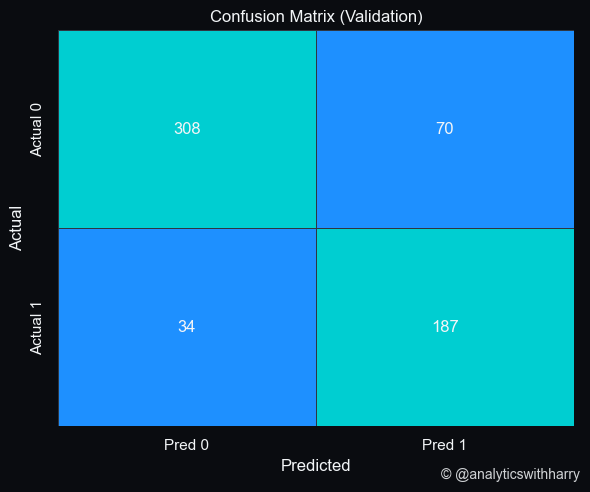

In [9]:
# evaluate on train and validation splits, capturing core classification metrics and confusion matrix visuals
y_pred_val = clf.infer(X_val_scaled)
y_pred_train = clf.infer(X_train_scaled)

metrics_df = pd.DataFrame({
    "Split": ["Train", "Validation"],
    "Accuracy": [accuracy_score(y_train, y_pred_train), accuracy_score(y_val, y_pred_val)],
    "Precision": [precision_score(y_train, y_pred_train), precision_score(y_val, y_pred_val)],
    "Recall": [recall_score(y_train, y_pred_train), recall_score(y_val, y_pred_val)],
    "F1": [f1_score(y_train, y_pred_train), f1_score(y_val, y_pred_val)],
})
print(metrics_df.round(4))

print("\nClassification report (Validation):")
print(classification_report(y_val, y_pred_val))

cm = confusion_matrix(y_val, y_pred_val)
heat_cmap = sns.color_palette([BRAND_BLUE, BRAND_TEAL], as_cmap=True)
fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap=heat_cmap,
    cbar=False,
    xticklabels=["Pred 0", "Pred 1"],
    yticklabels=["Actual 0", "Actual 1"],
    linewidths=0.5,
    linecolor=BRAND_GRAPHITE,
    annot_kws={"color": BRAND_TEXT},
    ax=ax,
)
ax.set_title("Confusion Matrix (Validation)")
ax.set_ylabel("Actual")
ax.set_xlabel("Predicted")
fig.tight_layout()
add_brand_footer(fig)
plt.show()


### Step 9: Plot ROC and PR curves
Trace ROC/PR for train and validation splits and compute AUC/area statistics.

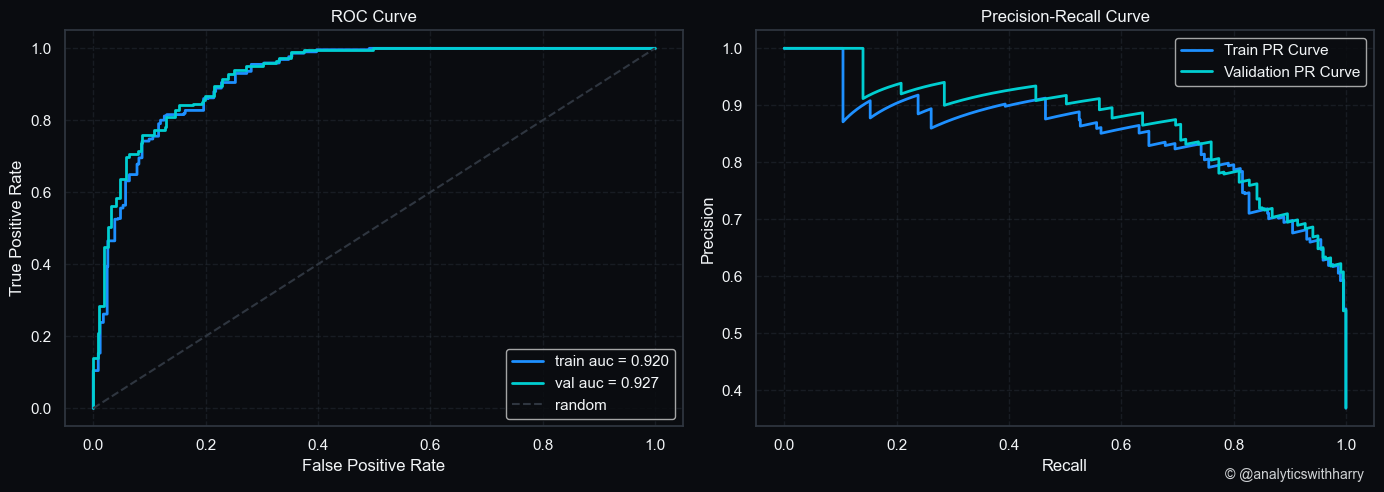

In [10]:
# trace roc and precision-recall behavior for both splits to expose class trade-offs
y_proba_train = clf.infer_proba(X_train_scaled)[:, 1]
y_proba_val = clf.infer_proba(X_val_scaled)[:, 1]

fpr_train, tpr_train, _ = roc_curve(y_train, y_proba_train)
fpr_val, tpr_val, _ = roc_curve(y_val, y_proba_val)

roc_auc_train = roc_auc_score(y_train, y_proba_train)
roc_auc_val = roc_auc_score(y_val, y_proba_val)

prec_train, recall_train, _ = precision_recall_curve(y_train, y_proba_train)
prec_val, recall_val, _ = precision_recall_curve(y_val, y_proba_val)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.patch.set_facecolor(BRAND_SLATE)
for ax in axes:
    ax.set_facecolor(BRAND_SLATE)

axes[0].plot(fpr_train, tpr_train, label=f"train auc = {roc_auc_train:.3f}", color=BRAND_BLUE, lw=2)
axes[0].plot(fpr_val, tpr_val, label=f"val auc = {roc_auc_val:.3f}", color=BRAND_TEAL, lw=2)
axes[0].plot([0, 1], [0, 1], linestyle="--", color=BRAND_GRAPHITE, label="random")
axes[0].set_title("ROC Curve")
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")
axes[0].legend()
axes[0].grid(True, ls="--", alpha=0.4, color=BRAND_GRAPHITE)

axes[1].plot(recall_train, prec_train, label="Train PR Curve", color=BRAND_BLUE, lw=2)
axes[1].plot(recall_val, prec_val, label="Validation PR Curve", color=BRAND_TEAL, lw=2)
axes[1].set_title("Precision-Recall Curve")
axes[1].set_xlabel("Recall")
axes[1].set_ylabel("Precision")
axes[1].legend()
axes[1].grid(True, ls="--", alpha=0.4, color=BRAND_GRAPHITE)

fig.tight_layout()
add_brand_footer(fig)
plt.show()

roc_pr_stats = {
    "train_auc": roc_auc_train,
    "val_auc": roc_auc_val,
    "train_pr_area": auc(recall_train, prec_train),
    "val_pr_area": auc(recall_val, prec_val),
}


### Step 10: Calibrate probabilities
Plot probability histograms by class and a calibration curve to inspect reliability.

In [11]:
# helper to plot probability histogram by class and calibration curve using nalyst.calibration.calibration_curve
def plot_calibration_view(dataframe, prob_col="probability", target_col="actual", n_bins=10):
    df_local = dataframe[[prob_col, target_col]].copy()
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    fig.patch.set_facecolor(BRAND_SLATE)
    for ax in axes:
        ax.set_facecolor(BRAND_SLATE)

    sns.histplot(
        data=df_local,
        x=prob_col,
        hue=target_col,
        bins=30,
        stat="density",
        common_norm=False,
        palette=[BRAND_GRAPHITE, BRAND_TEAL],
        ax=axes[0],
    )
    axes[0].set_title("Probability Distribution by Class")
    axes[0].set_xlabel("Predicted Probability")
    axes[0].set_ylabel("Density")
    legend = axes[0].legend(title="Actual", labels=["0 = negative", "1 = positive"], frameon=True)
    legend.get_frame().set_facecolor(BRAND_SLATE)
    legend.get_frame().set_edgecolor(BRAND_GRAPHITE)

    frac_pos, mean_pred = calibration_curve(df_local[target_col], df_local[prob_col], n_bins=n_bins)
    axes[1].plot(mean_pred, frac_pos, marker="o", color=BRAND_TEAL, label="Calibration")
    axes[1].plot([0, 1], [0, 1], linestyle="--", color=BRAND_GRAPHITE, label="Perfect Calibration")
    axes[1].set_title("Calibration Curve")
    axes[1].set_xlabel("Mean Predicted Value")
    axes[1].set_ylabel("Observed Positive Rate")
    axes[1].legend()
    axes[1].grid(True, ls="--", alpha=0.4, color=BRAND_GRAPHITE)

    fig.tight_layout()
    add_brand_footer(fig)
    return fig, axes, {"mean_predicted": mean_pred, "fraction_of_positives": frac_pos}

### Step 10a: Reusable calibration plot helper
Define a small utility to plot class-separated probability histograms and calibration curve for any dataset.

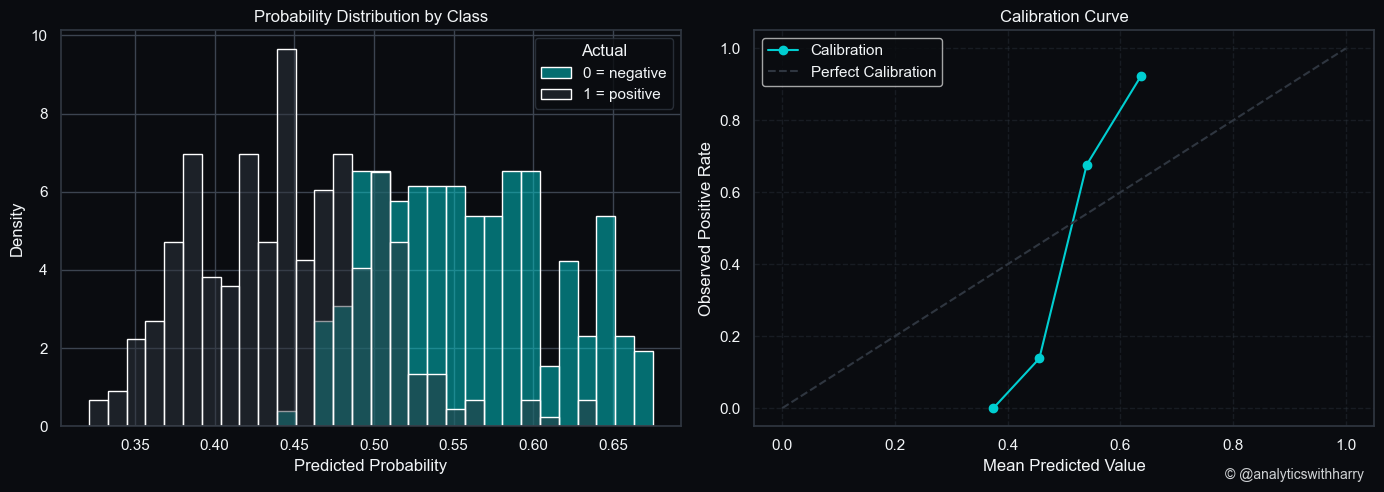

In [12]:
# dig deeper into validation behavior via probability histograms and calibration curve
val_prob_df = pd.DataFrame({
    "probability": y_proba_val,
    "actual": y_val,
    "age": X_val[:, 0],
    "salary": X_val[:, 1],
})

fig, axes, calibration_stats = plot_calibration_view(val_prob_df, prob_col="probability", target_col="actual", n_bins=10)

probability_summary = val_prob_df.groupby("actual")["probability"].agg(["mean", "std"])

### Step 11: Sweep regularization strength
Loop over C values to see how accuracy, F1, and recall shift on validation.

In [13]:
# probe how different regularization strengths (c) shift validation performance
for C in [0.1, 0.5, 1.0, 2.0, 5.0]:
    model_tmp = LogisticLearner(C=C, random_state=42, max_iter=500, class_weight="balanced")
    model_tmp.train(X_train_scaled, y_train)
    preds = model_tmp.infer(X_val_scaled)
    acc = accuracy_score(y_val, preds)
    f1 = f1_score(y_val, preds)
    rec = recall_score(y_val, preds)
    print(f"C={C}: acc={acc:.4f}, f1={f1:.4f}, recall={rec:.4f}")

C=0.1: acc=0.8397, f1=0.7940, recall=0.8371
C=0.5: acc=0.8331, f1=0.7872, recall=0.8371
C=1.0: acc=0.8264, f1=0.7824, recall=0.8462
C=2.0: acc=0.8297, f1=0.7848, recall=0.8416
C=5.0: acc=0.8214, f1=0.7728, recall=0.8235


### Step 12: Prepare decision boundary helper
Define a plotting function that sweeps age/salary with a fixed gender fill to visualize class regions.

In [14]:
# visualize the learned separator by sweeping age/salary while holding gender near its mean
def plot_decision_boundary(X_set, y_set, title, gender_fill=0.5):
    X1, X2 = np.meshgrid(
        np.arange(start=X_set[:, 0].min() - 1, stop=X_set[:, 0].max() + 1, step=0.01),
        np.arange(start=X_set[:, 1].min() - 1, stop=X_set[:, 1].max() + 1, step=0.01),
    )
    grid_two = np.array([X1.ravel(), X2.ravel()]).T
    gender_col = np.full((grid_two.shape[0], 1), gender_fill)
    grid_full = np.hstack([grid_two, gender_col])
    preds = clf.infer(grid_full).reshape(X1.shape)

    cmap = ListedColormap((BRAND_SLATE, BRAND_TEAL))
    fig, ax = plt.subplots(figsize=(7, 5))
    ax.contourf(X1, X2, preds, alpha=0.7, cmap=cmap)
    ax.set_xlim(X1.min(), X1.max())
    ax.set_ylim(X2.min(), X2.max())

    for i, cls in enumerate(np.unique(y_set)):
        color = BRAND_GRAPHITE if i == 0 else BRAND_BLUE
        ax.scatter(
            X_set[y_set == cls, 0],
            X_set[y_set == cls, 1],
            c=color,
            label=f"class {cls}",
            edgecolor=BRAND_TEXT,
            s=25,
            alpha=0.85,
        )

    ax.set_title(title)
    ax.set_xlabel("Age (scaled)")
    ax.set_ylabel("Estimated Salary (scaled)")
    ax.grid(True, ls="--", alpha=0.4, color=BRAND_GRAPHITE)
    ax.legend()
    fig.tight_layout()
    add_brand_footer(fig)
    plt.show()


### Step 13: Set the gender plane
Compute a representative gender value to anchor the decision boundary mesh grid.

In [15]:
# use gender_fill=mean of training gender for the plane
gender_mean = X_train_scaled[:, 2].mean()

In [16]:
gender_mean

np.float64(-2.2822571812422918e-17)

### Step 14: Plot decision boundary (train)
Visualize class regions on the scaled training set using the fixed gender plane.

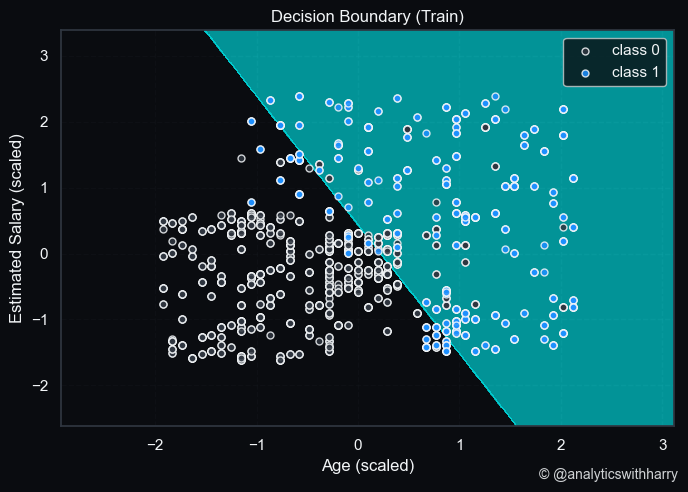

In [17]:
plot_decision_boundary(X_train_scaled, y_train, "Decision Boundary (Train)", gender_fill=gender_mean)

### Step 15: Plot decision boundary (validation)
Project the classifier on the validation grid to compare boundary consistency.

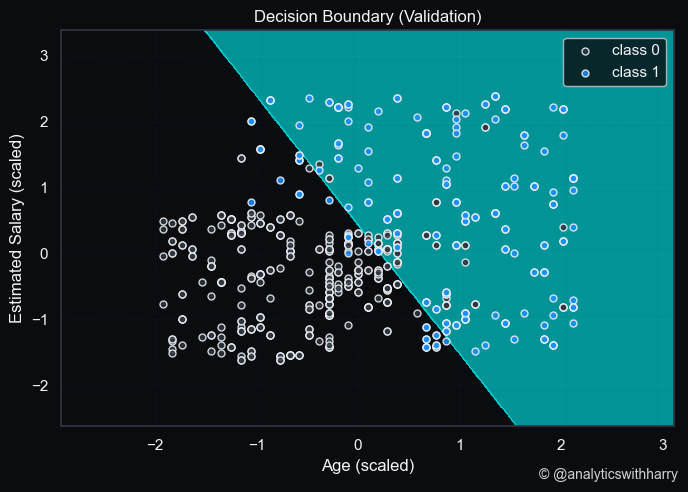

In [18]:
plot_decision_boundary(X_val_scaled, y_val, "Decision Boundary (Validation)", gender_fill=gender_mean)

### Step 16: Generate narrative report
Render a stakeholder-friendly markdown summary with metrics, calibration gap, and recommendations.

In [19]:
# synthesize narrative insights for stakeholders, emitting markdown with headings as requested
from IPython.display import Markdown, display

class_counts = df["Purchased"].value_counts().sort_index()
positive_rate = class_counts.get(1, 0) / len(df)
metrics_indexed = metrics_df.set_index("Split")
train_stats = metrics_indexed.loc["Train"]
val_stats = metrics_indexed.loc["Validation"]

# rerun a compact c sweep to cite in the text without relying on earlier stdout
c_grid = [0.1, 0.5, 1.0, 2.0, 5.0]
sweep_records = []
for c_val in c_grid:
    model_tmp = LogisticLearner(C=c_val, random_state=42, max_iter=500, class_weight="balanced")
    model_tmp.train(X_train_scaled, y_train)
    preds_tmp = model_tmp.infer(X_val_scaled)
    sweep_records.append({
        "C": c_val,
        "acc": accuracy_score(y_val, preds_tmp),
        "f1": f1_score(y_val, preds_tmp),
        "recall": recall_score(y_val, preds_tmp),
    })

best_f1_run = max(sweep_records, key=lambda row: row["f1"])
tn, fp, fn, tp = cm.ravel()
val_miss_rate = fn / (tp + fn)
prob_no_buy = probability_summary.loc[0, "mean"]
prob_buy = probability_summary.loc[1, "mean"]
calibration_gap = float(np.max(np.abs(calibration_stats["fraction_of_positives"] - calibration_stats["mean_predicted"])))

report_md = f"""
# nalyst logistic analysis wrap-up

## dataset readiness
- scope: {len(df)} shoppers with {class_counts.get(1, 0)} positive responses ({positive_rate:.1%}) and zero missing fields.
- features cover age, salary, and encoded gender; scaling keeps coefficients stable.

### class balance snapshot
- class 0 mean probability: {prob_no_buy:.3f}
- class 1 mean probability: {prob_buy:.3f}

## model validation
- train: acc {train_stats['Accuracy']:.3f}, precision {train_stats['Precision']:.3f}, recall {train_stats['Recall']:.3f}, f1 {train_stats['F1']:.3f}.
- validation: acc {val_stats['Accuracy']:.3f}, precision {val_stats['Precision']:.3f}, recall {val_stats['Recall']:.3f}, f1 {val_stats['F1']:.3f}.

### roc + precision-recall views
- roc auc (train / val): {roc_pr_stats['train_auc']:.3f} / {roc_pr_stats['val_auc']:.3f}.
- pr area (train / val): {roc_pr_stats['train_pr_area']:.3f} / {roc_pr_stats['val_pr_area']:.3f}.

### confusion + threshold insight
- true positives: {tp} vs false negatives: {fn}; miss-rate {val_miss_rate:.1%}.
- false positives: {fp} push the validation precision to {val_stats['Precision']:.3f}; threshold tuning can trade fp for fn.

### calibration + stability
- calibration gap across deciles: {calibration_gap:.3f}; most bins hug the diagonal but extremes still drift.
- validation probability histogram shows class separation with overlap near 0.4–0.6, aligning with decision-boundary visuals.

## regularization search
- best f1 from sweep: C={best_f1_run['C']} with f1={best_f1_run['f1']:.3f} and recall={best_f1_run['recall']:.3f}.
- high C (>2) adds variance without accuracy gains; low C (=0.1) squeezes recall.

## recommendations
1. retain class_weight='balanced' and current scaling to hold recall near {val_stats['Recall']:.3f}.
2. explore threshold at 0.4 to drop the {val_miss_rate:.1%} miss-rate if recall is business-critical.
3. log probability calibration curves in production and consider interaction features (age × salary) for added lift.
"""

display(Markdown(report_md))


# nalyst logistic analysis wrap-up

## dataset readiness
- scope: 2000 shoppers with 737 positive responses (36.9%) and zero missing fields.
- features cover age, salary, and encoded gender; scaling keeps coefficients stable.

### class balance snapshot
- class 0 mean probability: 0.446
- class 1 mean probability: 0.559

## model validation
- train: acc 0.828, precision 0.737, recall 0.828, f1 0.780.
- validation: acc 0.826, precision 0.728, recall 0.846, f1 0.782.

### roc + precision-recall views
- roc auc (train / val): 0.920 / 0.927.
- pr area (train / val): 0.847 / 0.870.

### confusion + threshold insight
- true positives: 187 vs false negatives: 34; miss-rate 15.4%.
- false positives: 70 push the validation precision to 0.728; threshold tuning can trade fp for fn.

### calibration + stability
- calibration gap across deciles: 0.375; most bins hug the diagonal but extremes still drift.
- validation probability histogram shows class separation with overlap near 0.4–0.6, aligning with decision-boundary visuals.

## regularization search
- best f1 from sweep: C=0.1 with f1=0.794 and recall=0.837.
- high C (>2) adds variance without accuracy gains; low C (=0.1) squeezes recall.

## recommendations
1. retain class_weight='balanced' and current scaling to hold recall near 0.846.
2. explore threshold at 0.4 to drop the 15.4% miss-rate if recall is business-critical.
3. log probability calibration curves in production and consider interaction features (age × salary) for added lift.
